# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from shap import TreeExplainer, initjs, force_plot

# Wrangle Data

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/imdb/'

In [3]:
# Read New York City property sales data

# Define Wrangle Function
def wrangle(movies_filepath, names_filepath, ratings_filepath, principals_filepath):
    
    # Read in the 4 csv files
    df_movies = pd.read_csv(movies_filepath)
    df_names = pd.read_csv(names_filepath,
                           usecols=['imdb_name_id', 'name'])
    df_ratings = pd.read_csv(ratings_filepath)
    df_title_pricipals = pd.read_csv(principals_filepath)

    # Drop columns that are redundant or have more than 60% null values
    df_movies.drop(columns= ['year', 'original_title'], inplace=True)
    df_movies.drop(83917 ,axis=0, inplace=True)
    df_movies.dropna(axis=1, thresh=len(df_movies)*.6, inplace=True)
    df_ratings.dropna(axis=1, thresh=len(df_ratings)*.6, inplace=True)
    df_title_pricipals.dropna(axis=1, thresh=len(df_title_pricipals)*.6, inplace=True)
      
    # Convert to datetime object
    df_movies['date_published'] = pd.to_datetime(df_movies['date_published'])
    
    # Merge the CSV files
    df_movies_ratings = pd.merge(df_movies, df_ratings, on='imdb_title_id')
    df_names_principals = pd.merge(df_names, df_title_pricipals, on='imdb_name_id')
    df = pd.merge(df_movies_ratings, df_names_principals, on='imdb_title_id')
    df.set_index('date_published', inplace=True)
    
    # Drop high cardinality columns
    for col in df.columns:
        if df[col].nunique() > 80_000:
            df.drop(columns=col, inplace=True)
    
    # Drop Data Leakage Column
    df.drop(columns=['avg_vote'], inplace=True)
    
    # Drop duplicate rows
    df.drop(columns=['ordering', 'category'], inplace=True)
    df.drop_duplicates(inplace=True)
    
    return df

In [4]:
# Run Wrangle Function to read in CSV files
df = wrangle(DATA_PATH + 'imdb_movies.csv',
             DATA_PATH + 'imdb_names.csv',
             DATA_PATH + 'imdb_ratings.csv',
             DATA_PATH + 'imdb_title_principals.csv')

# Split Data

In [5]:
# Split data into feature matrix and target vector
target = 'weighted_average_vote'

y = df[target]
X= df.drop(columns=target)

# Train on movies published before 2018, validate on 2018, test on after 2018
cutoff = 2018
mask = X.index.year < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[df.index.year == cutoff], y.loc[X.index.year == cutoff]
X_test, y_test = X.loc[~mask], y.loc[~mask]

<AxesSubplot:>

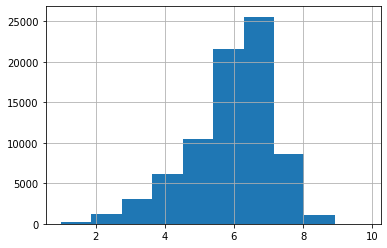

In [6]:
# Look at distribution of target
y_train.hist()

# Establish Baseline

In [7]:
y_pred = [y_train.mean()] * len(y_train)

print('Baseline MAE:', mean_absolute_error(y_pred, y_train))
print('Prediction', y_train.mean())

Baseline MAE: 0.9543148258663648
Prediction 5.916089876695121


# Build Models

In [8]:
#Build Ridge Model

model_r = make_pipeline(OrdinalEncoder(),
                        SimpleImputer(),
                        Ridge(alpha=20.0))
model_r.fit(X_train, y_train);

In [9]:
# Build XGB boosting regressor model

model_xgb= make_pipeline(OrdinalEncoder(),
                         SimpleImputer(),
                         StandardScaler(),
                         XGBRegressor(max_depth=4, alpha=2, n_jobs=-2, n_estimators=700))

model_xgb.fit(X_train, y_train);

# Hyperparameter Tuning

In [10]:
# params = {
#     'simpleimputer__strategy': ['mean'],
#     'xgbregressor__max_depth': [4],
#     'xgbregressor__alpha': [2],
#     'xgbregressor__n_estimators': range(200,301,25)
# }

# model_xgb_gs = GridSearchCV(model_xgb,
#                             param_grid= params,
#                             n_jobs= -2,
#                             cv=10,
#                             verbose=1)

# model_xgb_gs.fit(X_train, y_train);

In [11]:
# model_xgb_gs.best_score_

In [12]:
# model_xgb_gs.best_params_

# Check Metrics

In [13]:
print('Ridge Training MAE:', mean_absolute_error(y_train, model_r.predict(X_train)))
print('Ridge Validation MAE:', mean_absolute_error(y_val, model_r.predict(X_val)))

Ridge Training MAE: 0.07453938618207903
Ridge Validation MAE: 0.11939504835566833


In [14]:
print('XGBRegressor Training MAE:', mean_absolute_error(y_train, model_xgb.predict(X_train)))
print('XGBRegressor Validation MAE:', mean_absolute_error(y_val, model_xgb.predict(X_val)))

XGBRegressor Training MAE: 0.047050647137517054
XGBRegressor Validation MAE: 0.0990527158472399


In [15]:
print('XGBRegressor Test MAE (Run Only Once):', mean_absolute_error(y_test, model_xgb.predict(X_test)))

XGBRegressor Test MAE (Run Only Once): 0.11169788935212806


# Feature Importances

In [16]:
coefficients = model_xgb.named_steps['xgbregressor'].feature_importances_
features = model_xgb.named_steps['ordinalencoder'].get_feature_names()
feature_importances = pd.Series(coefficients, index=features).sort_values(key=abs).tail(10)

In [17]:
# calculate the Pearson's correlation between two variables
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
# calculate Pearson's correlation
df.dropna(inplace=True)
corr, _ = pearsonr(df['weighted_average_vote'], df['males_allages_avg_vote'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.988


Text(0.5, 1.0, 'Feature importances for XGBRegressor Model')

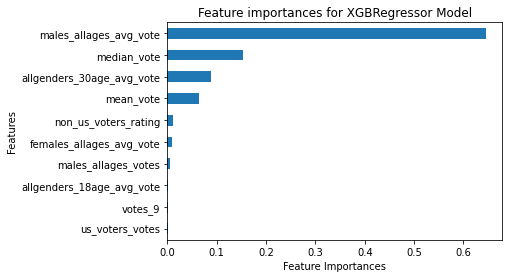

In [18]:
feature_importances.plot(kind='barh')
plt.xlabel('Feature Importances')
plt.ylabel('Features')
plt.title('Feature importances for XGBRegressor Model')

In [19]:
# Strenght of males_allages_votes feature from overrepresentation of male votes in the dataset

df[['males_allages_votes', 'females_allages_votes']]

,males_allages_votes,females_allages_votes
date_published,,
1894-10-09,97.0,35.0
1906-12-26,425.0,50.0
1912-11-13,299.0,39.0
1911-03-06,1607.0,215.0
1913-01-01,354.0,31.0
...,...,...
2019-04-18,229.0,71.0
2020-04-03,6270.0,1161.0
2019-10-25,4577.0,121.0


# Permutation Importances

In [20]:
perm_imp = permutation_importance(model_xgb,
                                  X_val,
                                  y_val,
                                  n_jobs=-2,
                                  random_state=42)

In [21]:
data = pd.DataFrame({'importances_mean': perm_imp['importances_mean']}, index=X_val.columns)

Text(0.5, 1.0, 'Permutation importances for XGBRegressor Model')

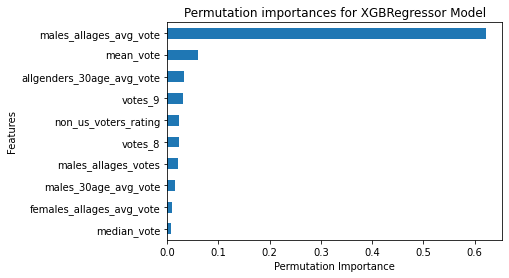

In [22]:
data['importances_mean'].sort_values().tail(10).plot(kind='barh')
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Permutation importances for XGBRegressor Model')

# 1 Feature Partial Dependence Plot

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_ax': <AxesSubplot:xlabel='males_allages_avg_vote'>})

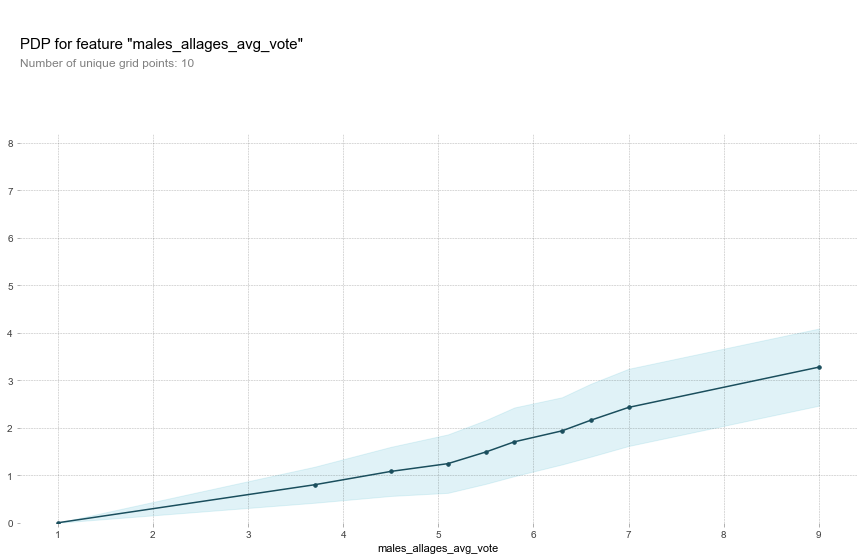

In [23]:
feature = 'males_allages_avg_vote'

isolate = pdp_isolate(model = model_xgb,
                      dataset = X_val,
                      model_features = X_val.columns,
                     feature=feature)

pdp_plot(isolate, feature_name=feature)